# Projet : Classification des émotions avec transfert learning (Dataset FER)

## Introduction
Ce projet utilise **le transfert learning** pour reconnaître les émotions à partir d’images du dataset FER. L'objectif est de tirer parti d’un modèle pré-entraîné sur un large corpus d'images (comme ResNet ou VGG) pour une classification fine des émotions. Cette méthode permet d’accélérer l’entraînement tout en améliorant la précision grâce aux représentations apprises par des réseaux profonds robustes.

---

## Structure générale du projet
1. **Analyse exploratoire des données**  
   Comprendre la répartition des classes et identifier d'éventuelles anomalies dans les données.
2. **Prétraitement des données**  
   Préparer les images avec des transformations cohérentes avec l’architecture du modèle pré-entraîné.
3. **Configuration du modèle avec transfert learning**  
   Charger un modèle pré-entraîné, remplacer les couches de sortie pour adapter les classes du dataset, et choisir les parties du modèle à entraîner.
4. **Entraînement et validation**  
   Ajuster le modèle sur les données d’entraînement, valider les performances sur les données de validation.
5. **Visualisations et analyse des résultats**  
   Comprendre les performances grâce à des métriques visuelles telles que les courbes de perte, de précision et une matrice de confusion.

---


## 1 - Prétraitement des données

### Objectif
Préparer les images pour qu'elles soient compatibles avec le modèle, tout en améliorant la robustesse via des augmentations de données.

### Étapes
1. **Redimensionner les images** à une taille uniforme (48x48).  
   Cela simplifie le traitement et réduit la mémoire nécessaire.
2. **Appliquer des augmentations** pour les données d'entraînement :  
   - Flips horizontaux aléatoires,
   - Rotations aléatoires,
   - Normalisation pour standardiser les pixels.
3. **Normalisation** sur l'ensemble des données (train et validation) avec des moyennes et écarts-types spécifiques.

### Visualisation
Affiche un échantillon d'images augmentées pour vérifier visuellement que les transformations fonctionnent comme prévu.

In [24]:
# Importation des librairies nécessaires pour effectuer le travail
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm

In [25]:
# Vérification de l'appareil GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

Device utilisé : cpu


In [26]:
def visualize_dataset_structure(dataset_path):
    """
    Affiche la structure du dataset en comptant les images dans chaque classe.
    """
    class_counts = {}
    for root, dirs, files in os.walk(dataset_path):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)

    # Visualisation des données par classe
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.title('Distribution des données dans le dataset')
    plt.xticks(rotation=45)
    plt.show()

Structure des données dans le dossier Train :


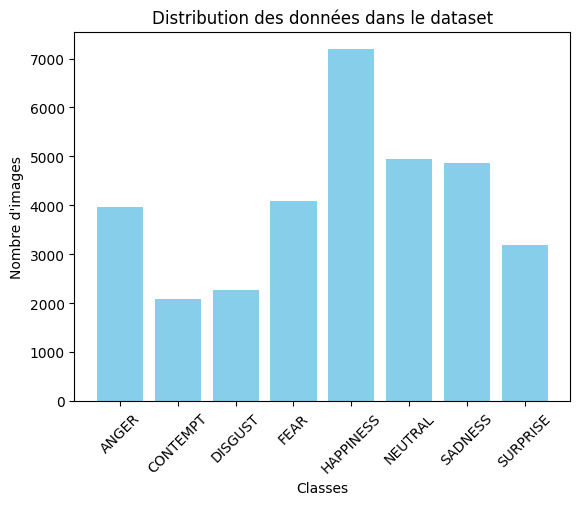

Structure des données dans le dossier Validation :


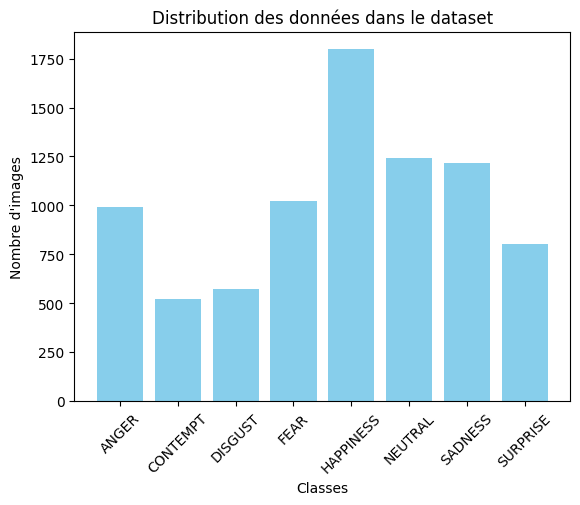

In [27]:
# Chemin vers le dataset
dataset_path_train = "D:\\Projets\\Projets personnels\\CNN_Sentiment_Viz\\FERPlus-master-images\\train"
dataset_path_val = "D:\\Projets\\Projets personnels\\CNN_Sentiment_Viz\\FERPlus-master-images\\val"

print("Structure des données dans le dossier Train :")
visualize_dataset_structure(dataset_path_train)

print("Structure des données dans le dossier Validation :")
visualize_dataset_structure(dataset_path_val)

In [28]:
# Transformations améliorées pour l'entraînement
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),             # Taille compatible avec ResNet
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ResNet
])

# Transformations pour la validation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# Chargement des datasets
train_dataset = datasets.ImageFolder(root=dataset_path_train, transform=transform_train)
val_dataset = datasets.ImageFolder(root=dataset_path_val, transform=transform_val)

In [30]:
# Création des DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [31]:
# Affichage des classes
classes = train_dataset.classes
print(f"Classes du dataset : {classes}")

Classes du dataset : ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1759479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-0.30553368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
C

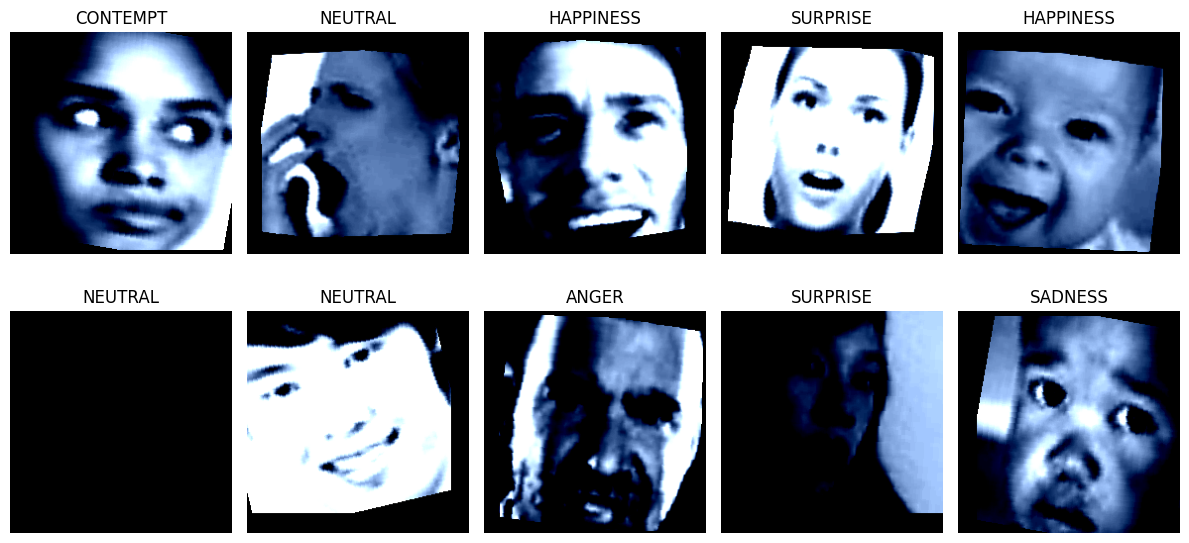

In [32]:
def visualize_augmented_samples(data_loader, classes):
    """
    Visualiser 10 exemples d'images augmentées avec leurs étiquettes.

    Arguments:
    - data_loader : DataLoader pour les données.
    - classes : Liste des noms des classes.
    """
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Définir une figure pour afficher 10 images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        image = images[i].permute(1, 2, 0)  
        image = image.numpy()

        if image.shape[2] == 1: 
            ax.imshow(image.squeeze(), cmap='gray')
        else: 
            ax.imshow(image)

        ax.set_title(classes[labels[i].item()])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmented_samples(train_loader, classes)

## Configuration du modèle avec transfert learning
---
### Objectif
Adapter un modèle pré-entraîné pour la tâche spécifique de classification des émotions.
---
### Étapes
1. **Chargement du modèle pré-entraîné** : Utiliser un réseau comme ResNet18 ou VGG16, pré-entraîné sur ImageNet.  
2. **Remplacement de la couche de sortie** :  
   - Supprimer la dernière couche entièrement connectée.  
   - Ajouter une nouvelle couche linéaire avec un nombre de neurones égal au nombre de classes (`len(classes)`).
3. **Gel des couches** (optionnel) :  
   - Geler les couches convolutives pour ne pas les réentraîner (utile pour économiser du temps).  
   - Réentraîner uniquement les couches ajoutées.

In [33]:
# Configuration des hyperparamètres
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
FREEZE_EPOCHS = 5  # Nombre d'époques pour l'entraînement avec couches gelées

# Chargement du modèle pré-entraîné (EfficientNet-B0)
model = models.efficientnet_b0(pretrained=True)

# Modification de la couche fully connected
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, len(classes))
)

# Gel des couches convolutives
def freeze_layers(model):
    for param in model.features.parameters():
        param.requires_grad = False

# Dégel des couches
def unfreeze_layers(model):
    for param in model.parameters():
        param.requires_grad = True

# Gel initial des couches
freeze_layers(model)

# Déplacement vers GPU/CPU
model = model.to(device)

In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

# Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Boucle d'entraînement améliorée
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, is_frozen=True):
    """
    Entraîne le modèle avec early stopping et learning rate scheduling.
    
    Args :
    - model : le modèle PyTorch à entraîner
    - train_loader : DataLoader pour les données d'entraînement
    - val_loader : DataLoader pour les données de validation
    - criterion : fonction de perte
    - optimizer : optimiseur
    - epochs : nombre d'époques maximum
    - is_frozen : si True, utilise un learning rate plus élevé pour les couches dégelées

    Returns :
    - train_losses : liste des pertes d'entraînement par époque
    - val_losses : liste des pertes de validation par époque
    - val_accuracies : liste des précisions sur le jeu de validation par époque
    """
    train_losses, val_losses, val_accuracies = [], [], []
    early_stopping = EarlyStopping(patience=5)
    
    # Configuration du scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * (10 if not is_frozen else 1),
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Phase d'entraînement
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Phase de validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

        # Early Stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, val_losses, val_accuracies

# Entraînement
epochs = 20
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/20


Training Epoch 1:  64%|██████▍   | 328/511 [13:48<07:41,  2.52s/it]

In [ ]:
# Entraînement en deux phases

# Phase 1 : Entraînement avec couches gelées
print("Phase 1 : Entraînement avec couches gelées")
train_losses1, val_losses1, val_accuracies1 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    FREEZE_EPOCHS,
    is_frozen=True
)

# Dégel des couches
print("\nDégel des couches pour la phase 2")
unfreeze_layers(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE/10)  # Learning rate plus faible pour le fine-tuning

# Phase 2 : Fine-tuning de tout le modèle
print("\nPhase 2 : Fine-tuning du modèle complet")
train_losses2, val_losses2, val_accuracies2 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    NUM_EPOCHS - FREEZE_EPOCHS,
    is_frozen=False
)


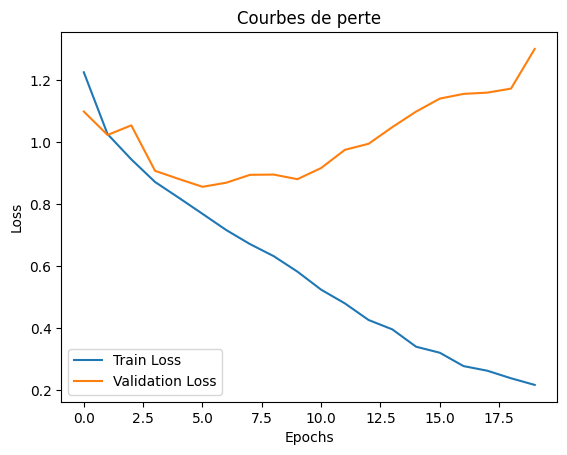

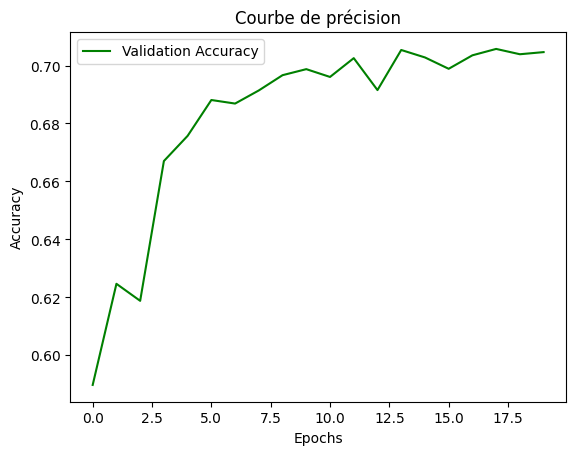

In [ ]:
# Courbes de perte
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbes de perte')
plt.show()

# Courbes de précision
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbe de précision')
plt.show()

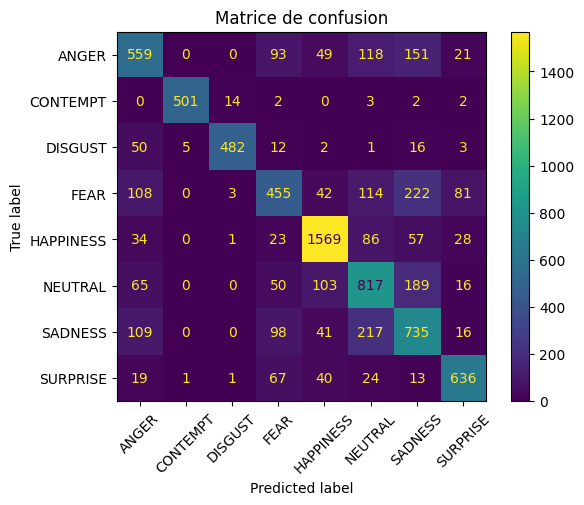

In [ ]:
def plot_confusion_matrix(model, loader, classes):
    """
    Génère une matrice de confusion pour les données de validation.
    """
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title('Matrice de confusion')
    plt.show()

plot_confusion_matrix(model, val_loader, classes)

In [ ]:
# Chemin du dossier et nom du fichier
dossier_sauvegarde = "modele"
nom_fichier = "transfert_learning_emotion_model.pth"

# Créer le dossier s'il n'existe pas
os.makedirs(dossier_sauvegarde, exist_ok=True)

# Chemin complet du fichier
chemin_complet = os.path.join(dossier_sauvegarde, nom_fichier)

# Sauvegarder le modèle
torch.save(model.state_dict(), chemin_complet)

print(f"Modèle sauvegardé dans : {chemin_complet}")

Modèle sauvegardé dans : modele\transfert_learning_emotion_model.pth
